## Plot replay composition by day

In [23]:
import os
import pickle
import spyglass as nd
import pandas as pd
import statsmodels.api as sm
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,
                                   RippleTimes,
                                   DecodeResultsLinear,get_linearization_map,
                                   find_ripple_times,classify_ripples,classify_ripple_content)

In [25]:
nwb_file_names=['molly20220415.nwb','molly20220416.nwb',
                'molly20220417.nwb','molly20220418.nwb','molly20220419.nwb','molly20220420.nwb']

# the only cell to be edited

# 'molly20220415.nwb': run only session 4 6 8
# all Seq2 days
nwb_file_names = ['molly20220415.nwb','molly20220416.nwb',
                  'molly20220417.nwb','molly20220418.nwb',
                  'molly20220419.nwb','molly20220420.nwb']
all_epochs_flag=[[4,6,8],[],[],[],[],[]]


#nwb_file_names = ['lewis20240107.nwb','lewis20240108.nwb',
#                  'lewis20240109.nwb','lewis20240110.nwb',
#                  'lewis20240116.nwb','lewis20240118.nwb',
#                  'lewis20240119.nwb','lewis20240120.nwb']
nwb_file_names = ['lewis20240106.nwb','lewis20240107.nwb','lewis20240108.nwb','lewis20240109.nwb','lewis20240118.nwb']
encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
all_epochs_flag=[[],[],[],[],[],[],[],[]]


In [26]:
H=[]
H_boot_mean=[]
H_boot_CI_l=[]
H_boot_CI_u=[]

O=[]
O_boot_mean=[]
O_boot_CI_l=[]
O_boot_CI_u=[]

for nwb_file_name in nwb_file_names:
    nwb_copy_file_name=get_nwb_copy_filename(nwb_file_name)
    decoding_path=(DecodeResultsLinear &
               {'nwb_file_name': nwb_copy_file_name}).fetch('posterior')[0]
    animal=nwb_file_name[:5]
    date=nwb_copy_file_name[5:-5]
    resultfolder=os.path.join(os.path.split(decoding_path)[0],'analysis')
    
    data=pickle.load(open(os.path.join(resultfolder,
                              'replay_category_'+animal+'_'+date+'.p'),"rb"))
    
    H.append(data['categories_H_day_prop'])
    H_boot_mean.append(data['H_boot_mean'])
    H_boot_CI_l.append(data['H_boot_CI'][0])
    H_boot_CI_u.append(data['H_boot_CI'][1])
    
    #O.append(data['categories_O_day_prop'])
    #O_boot_mean.append(data['O_boot_mean'])
    #O_boot_CI_l.append(data['O_boot_CI'][0])
    #O_boot_CI_u.append(data['O_boot_CI'][1])
H_boot_mean=np.array(H_boot_mean)
H_boot_CI_l=np.array(H_boot_CI_l)
H_boot_CI_u=np.array(H_boot_CI_u)

#O_boot_mean=np.array(O_boot_mean)
#O_boot_CI_l=np.array(O_boot_CI_l)
#O_boot_CI_u=np.array(O_boot_CI_u)

In [27]:
np.array(H_boot_mean)

array([[0.        , 0.26384041, 0.36461201, 0.37154757],
       [0.        , 0.25429185, 0.42619236, 0.31951578],
       [0.        , 0.39687748, 0.36471432, 0.2384082 ],
       [0.        , 0.40072968, 0.30511009, 0.29416022],
       [0.        , 0.27225856, 0.30256043, 0.42518101]])

Text(1.5, 1.05, 'Replays at HOME')

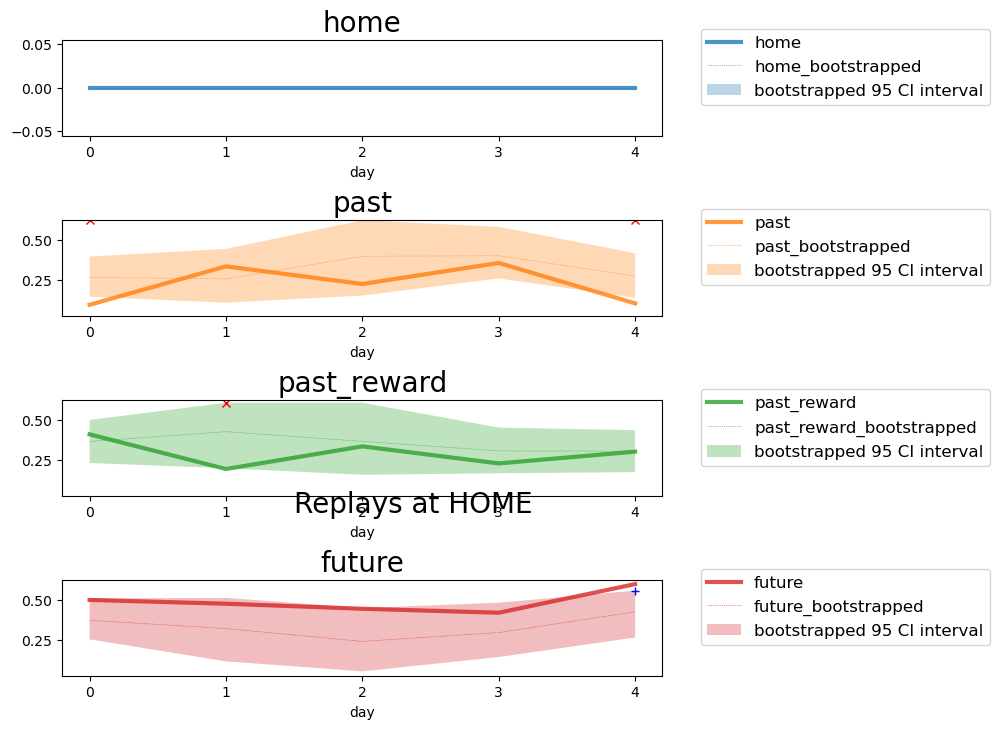

In [28]:
category_names_H=list(H[0].keys())

fig,axes=plt.subplots(len(category_names_H),1,figsize=(12, 12))

# plot result
for c in range(len(category_names_H)):
    data_result=[H[d][category_names_H[c]] for d in range(len(H))]
    axes[c].plot(data_result,linewidth=3,color='C'+str(c),label=category_names_H[c],alpha=0.8)
    axes[c].plot(H_boot_mean[:,c],linewidth=0.5,color='C'+str(c),label=category_names_H[c]+'_bootstrapped',linestyle=':')
    axes[c].fill_between(np.arange(len(H)),
                         H_boot_CI_u[:,c],H_boot_CI_l[:,c],facecolor='C'+str(c), alpha=0.3,label='bootstrapped 95 CI interval')
    
    significant_ind_more=np.argwhere(data_result>(H_boot_CI_u[:,c]))
    significant_ind_less=np.argwhere(data_result<(H_boot_CI_l[:,c]))
    #significant_ind=np.argwhere(np.logical_or(
    #    mean_data[:,c]>(std_up_random[:,c]),
    #    mean_data[:,c]<(std_down_random[:,c]))
    axes[c].plot(significant_ind_more,np.ones_like(significant_ind_more)*np.max(H_boot_CI_u[:,c]),'+',color='b')
    axes[c].plot(significant_ind_less,np.ones_like(significant_ind_less)*np.max(H_boot_CI_u[:,c]),'x',color='r')
    
    # if c==3:
    #     data_result=[H[d][category_names_H[2]] for d in range(len(H))]
    #     axes[c].plot(data_result,linewidth=3,color='C'+str(2),label=category_names_H[2],alpha=0.5)
    #     axes[c].plot(H_boot_mean[:,2],linewidth=0.5,color='C'+str(2),label=category_names_H[2]+'_bootstrapped',linestyle=':')
    #     axes[c].fill_between(np.arange(len(H)),
    #                      H_boot_CI_u[:,2],H_boot_CI_l[:,2],facecolor='C'+str(2), alpha=0.3,label='bootstrapped 95 CI interval')
        
    axes[c].set_position([0.06,1-(c+1)*0.15-0.05,0.5,0.08])
    axes[c].legend(fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axes[c].set_xticks(np.arange(len(H)));
    axes[c].set_xlabel('day');
    axes[c].set_title(category_names_H[c],fontsize=20)
    
axes[1].sharey(axes[3])   
axes[2].sharey(axes[3])  
plt.text(1.5,1.05,'Replays at HOME',fontsize=20)    
#plt.savefig(os.path.join(figurefolder,'C_Markovianess_'+animal+'.png'),bbox_inches='tight',dpi=500)
    

In [29]:
category_names_O=list(O[0].keys())

fig,axes=plt.subplots(len(category_names_O),1,figsize=(12, 12))

# plot result
for c in range(len(category_names_O)):
    data_result=[O[d][category_names_O[c]] for d in range(len(H))]
    axes[c].plot(data_result,linewidth=3,color='C'+str(c),label=category_names_O[c],alpha=0.8)
    axes[c].plot(O_boot_mean[:,c],linewidth=0.5,color='C'+str(c),label=category_names_O[c]+'_bootstrapped',linestyle=':')
    axes[c].fill_between(np.arange(len(O)),
                         O_boot_CI_u[:,c],O_boot_CI_l[:,c],facecolor='C9', alpha=0.3,label='bootstrapped 95 CI interval')
    significant_ind_more=np.argwhere(data_result>(O_boot_CI_u[:,c]))
    significant_ind_less=np.argwhere(data_result<(O_boot_CI_l[:,c]))
    axes[c].plot(significant_ind_more,np.ones_like(significant_ind_more)*np.max(O_boot_CI_u[:,c]),'+',color='b')
    axes[c].plot(significant_ind_less,np.ones_like(significant_ind_less)*np.max(O_boot_CI_u[:,c]),'x',color='r')
        
    axes[c].set_position([0.06,1-(c+1)*0.15-0.05,0.5,0.08])
    axes[c].legend(fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axes[c].set_xticks(np.arange(len(H)));
    axes[c].set_xlabel('day');
    #axes[0].set_xticklabels(['1],fontsize=16);
    axes[c].set_title(category_names_O[c],fontsize=20)
plt.text(1.5,3.1,'Replays at ARMs',fontsize=20)    
#plt.savefig(os.path.join(figurefolder,'C_Markovianess_'+animal+'.png'),bbox_inches='tight',dpi=500)
    

IndexError: list index out of range